# Prompt Visualization


This is the overall code for experiment 1, used to benchmark prompt pattern performance per model. While there are some other graphs for model performance, it is more exhaustively investigated in the next experiments.

### imports

In [ ]:
!pip install spacy
!pip install rapidfuzz
import pandas as pd
import numpy as np
import json
import spacy
from rapidfuzz import process, fuzz
import ast
nlp = spacy.load('en_core_web_sm')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from wordcloud import WordCloud
import string
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
prompts_df = pd.read_csv('prompts.csv', sep="\t")

## pre-processing

In [ ]:
def process_dataset(output_file, model_type):
  # Load the JSONL file
  results = []
  with open(output_file, 'r') as f:
      for line in f:
          results.append(json.loads(line))

  # Convert results into a DataFrame
  results_df = pd.DataFrame(results)

  # Define a function to safely extract the model's response
  def extract_model_response(response):
        # Try to extract the content from the response
        return response['body']['choices'][0]['message']['content']

  # Apply the function to extract the model responses
  results_df['model_response'] = results_df['response'].apply(extract_model_response)

  # Merge the results DataFrame with the original prompts_df on 'custom_id'
  # Ensure the custom_id format in results_df matches the index format in prompts_df
  if model_type == 'mistral':
    merged_df = prompts_df.merge(results_df[['custom_id', 'model_response']], left_on=prompts_df.index.map(lambda x: f"task-parse-mistral-{x}"), right_on='custom_id', how='left')
  else:
    merged_df = prompts_df.merge(results_df[['custom_id', 'model_response']], left_on=prompts_df.index.map(lambda x: f"task-parse-{x}"), right_on='custom_id', how='left')

  # Randomly reduce the number of 'explicit_hate' and 'implicit_hate' rows by half
  classes_to_reduce = ['explicit_hate', 'implicit_hate']
  reduced_dfs = []
  for cls in classes_to_reduce:
      cls_df = merged_df[merged_df['class'] == cls]
      reduced_cls_df = cls_df.sample(frac=0.5, random_state=42)
      reduced_dfs.append(reduced_cls_df)
  # Get the rest of the data
  other_df = merged_df[~merged_df['class'].isin(classes_to_reduce)]
  # Concatenate the dataframes
  merged_df = pd.concat(reduced_dfs + [other_df], ignore_index=True)

  # Drop the extra 'custom_id' column after merging if needed
  merged_df = merged_df.drop(columns=['custom_id'])

  merged_df['target'] = merged_df['target'].apply(lambda x: x if isinstance(x, str) else [])
  merged_df = merged_df.loc[:, ~merged_df.columns.str.contains('^Unnamed')]

  # Create target groups and classification columns
  merged_df['pred_class'] = merged_df['model_response'].apply(lambda x: json.loads(x)['classification'])
  merged_df['pred_target'] = merged_df['model_response'].apply(lambda x: json.loads(x)['target_groups'])

  # Renaming class, and creating the multi-class classification
  merged_df['binary_class'] = merged_df['class'].apply(lambda x: 'not hateful' if x == 'not_hate' else 'hateful')
  merged_df = merged_df.rename(columns={'class': 'multiclass_class'})

  # Finally, drop model_response
  merged_df.drop(columns=['model_response'], inplace=True)

  # Also drop system prompt, and user prompt
  merged_df.drop(columns=['system_prompt', 'user_prompt'], inplace=True)

  # Rename the ID
  merged_df.rename(columns={'id': 'post_id'}, inplace=True)


  return df

# sequential modelling attempt


In [ ]:
gpt = process_dataset('batch_output_gpt.jsonl', 'gpt')
mistral = process_dataset('batch_output_mistral.jsonl', 'mistral')

In [ ]:
df1 = gpt.copy()
df2 = mistral.copy()

In [ ]:
df1['pred_class'].value_counts()

,count
pred_class,
hateful,3587
not hateful,2413


In [ ]:
df2['pred_class'].value_counts()

,count
pred_class,
hateful,3875
not hateful,2125


In [ ]:
# Step 1: Merge the DataFrames by index
df_combined = pd.concat([df1, df2], axis=1, keys=['model1', 'model2'])

# Step 2: Flatten the multi-level column names (created by using 'keys')
df_combined.columns = ['_'.join(col).strip() for col in df_combined.columns.values]

# Step 2.1: Check the column names to ensure the merge happened as expected
print(df_combined.columns)# Step 3: Define the combined prediction function


Index(['model1_multiclass_class', 'model1_target', 'model1_post_id',
       'model1_function_name', 'model1_pred_class', 'model1_pred_target',
       'model1_binary_class', 'model1_standard_target',
       'model1_standard_pred_target', 'model2_multiclass_class',
       'model2_target', 'model2_post_id', 'model2_function_name',
       'model2_pred_class', 'model2_pred_target', 'model2_binary_class',
       'model2_standard_target', 'model2_standard_pred_target'],
      dtype='object')


In [ ]:
df_combined['pred_class'].value_counts()

,count
pred_class,
hateful,3466
not hateful,2534


In [ ]:
def test_func(df):
    print("=== Overall Classification Metrics ===")
    y_true = df['binary_class']
    y_pred = df['pred_class']
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='hateful', zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label='hateful', zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label='hateful', zero_division=0)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision (Hateful): {precision:.2f}")
    print(f"Recall (Hateful): {recall:.2f}")
    print(f"F1 Score (Hateful): {f1:.2f}\n")

    # Detailed Classification Report with Macro and Weighted Averages
    print("=== Detailed Classification Report ===")
    report = classification_report(
        y_true, y_pred,
        labels=['not hateful', 'hateful'],
        target_names=['Not Hateful', 'Hateful'],
        digits=2
    )
    print(report)

test_func(df_combined)

=== Overall Classification Metrics ===
Accuracy: 0.82
Precision (Hateful): 0.77
Recall (Hateful): 0.90
F1 Score (Hateful): 0.83

=== Detailed Classification Report ===
              precision    recall  f1-score   support

 Not Hateful       0.88      0.74      0.80      3000
     Hateful       0.77      0.90      0.83      3000

    accuracy                           0.82      6000
   macro avg       0.83      0.82      0.82      6000
weighted avg       0.83      0.82      0.82      6000



# Visualization

## boilerpalte

In [ ]:
def print_hate_speech_metrics(df):
    """
    Prints key statistics and insights from a hate speech classification results DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing classification results with the following columns:
        - post_id: number
        - text: string containing the post content
        - standard_target: list of strings
        - standard_pred_target: list of strings
        - multiclass_class: 'implicit_hate', 'explicit_hate', or 'not_hate'
        - binary_class: 'hateful' or 'not hateful'
        - pred_class: 'hateful' or 'not hateful'
        - function_name: string representing the prompt type used
    """
    # Ensure list columns are actual lists
    df['standard_target'] = df['standard_target'].apply(lambda x: x if isinstance(x, list) else [])
    df['standard_pred_target'] = df['standard_pred_target'].apply(lambda x: x if isinstance(x, list) else [])

    # Overall Metrics
    print("=== Overall Classification Metrics ===")
    y_true = df['binary_class']
    y_pred = df['pred_class']
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='hateful', zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label='hateful', zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label='hateful', zero_division=0)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision (Hateful): {precision:.2f}")
    print(f"Recall (Hateful): {recall:.2f}")
    print(f"F1 Score (Hateful): {f1:.2f}\n")

    # Detailed Classification Report with Macro and Weighted Averages
    print("=== Detailed Classification Report ===")
    report = classification_report(
        y_true, y_pred,
        labels=['not hateful', 'hateful'],
        target_names=['Not Hateful', 'Hateful'],
        digits=2
    )
    print(report)

    # Metrics by Function Name
    print("=== Metrics by Function Name ===")
    function_metrics = df.groupby('function_name').apply(
        lambda x: pd.Series({
            'Accuracy': accuracy_score(x['binary_class'], x['pred_class']),
            'Precision (Hateful)': precision_score(x['binary_class'], x['pred_class'], pos_label='hateful', zero_division=0),
            'Recall (Hateful)': recall_score(x['binary_class'], x['pred_class'], pos_label='hateful', zero_division=0),
            'F1 Score (Hateful)': f1_score(x['binary_class'], x['pred_class'], pos_label='hateful', zero_division=0)
        })
    ).reset_index()
    print(function_metrics.to_string(index=False))
    print()

    # Misclassifications by Multiclass Class
    print("=== Misclassifications by Multiclass Class ===")
    misclassified = df[df['binary_class'] != df['pred_class']]
    misclass_counts = misclassified['multiclass_class'].value_counts()
    print(misclass_counts.to_string())
    print()

    # False Positive Rate and False Negative Rate
    print("=== Error Rates ===")
    cm = confusion_matrix(y_true, y_pred, labels=['not hateful', 'hateful'])
    if cm.shape == (2,2):
        tn, fp, fn, tp = cm.ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        print(f"False Positive Rate (FPR): {fpr:.2f}")
        print(f"False Negative Rate (FNR): {fnr:.2f}\n")
    else:
        print("Confusion matrix does not have the expected shape for binary classification.\n")

    # Most Misclassified Target Groups
    print("=== Most Misclassified Target Groups ===")
    # Focus on hateful instances
    hateful_df = df[df['binary_class'] == 'hateful']
    # Misclassified if pred_class != binary_class
    misclassified_hateful = hateful_df[hateful_df['pred_class'] != hateful_df['binary_class']]

    # False Positives: Predicted targets not in actual
    fp_targets = misclassified_hateful.apply(
        lambda row: set(row['standard_pred_target']) - set(row['standard_target']), axis=1
    ).explode()
    fp_counts = fp_targets.value_counts().dropna()
    print("False Positive Target Groups:")
    if not fp_counts.empty:
        print(fp_counts.to_string())
    else:
        print("None")
    print()

    # False Negatives: Actual targets not predicted
    fn_targets = misclassified_hateful.apply(
        lambda row: set(row['standard_target']) - set(row['standard_pred_target']), axis=1
    ).explode()
    fn_counts = fn_targets.value_counts().dropna()
    print("False Negative Target Groups:")
    if not fn_counts.empty:
        print(fn_counts.to_string())
    else:
        print("None")
    print()

    # Top 10 Common Targets
    print("=== Top 10 Common Targets ===")
    all_targets = hateful_df['standard_target'].explode()
    all_pred_targets = hateful_df['standard_pred_target'].explode()
    target_counter = Counter(all_targets.dropna())
    pred_target_counter = Counter(all_pred_targets.dropna())

    top_targets = pd.DataFrame({
        'Actual': pd.Series(target_counter),
        'Predicted': pd.Series(pred_target_counter)
    }).fillna(0).sort_values(by='Actual', ascending=False).head(10)
    print(top_targets.to_string())
    print()

    # Additional Metrics: Macro and Weighted Averages
    print("=== Macro and Weighted Averages ===")
    metrics_df = pd.DataFrame(
        classification_report(
            y_true, y_pred,
            labels=['not hateful', 'hateful'],
            target_names=['Not Hateful', 'Hateful'],
            output_dict=True
        )
    ).transpose()
    if 'macro avg' in metrics_df.index and 'weighted avg' in metrics_df.index:
        print(f"Macro Average Precision: {metrics_df.loc['macro avg', 'precision']:.2f}")
        print(f"Macro Average Recall: {metrics_df.loc['macro avg', 'recall']:.2f}")
        print(f"Macro Average F1-Score: {metrics_df.loc['macro avg', 'f1-score']:.2f}")
        print(f"Weighted Average Precision: {metrics_df.loc['weighted avg', 'precision']:.2f}")
        print(f"Weighted Average Recall: {metrics_df.loc['weighted avg', 'recall']:.2f}")
        print(f"Weighted Average F1-Score: {metrics_df.loc['weighted avg', 'f1-score']:.2f}\n")
    else:
        print("Macro and Weighted averages not found in classification report.\n")

    print("Printed metrics complete.")


def plot_hate_speech_results(df):
    """
    Generates visualizations for key statistics and insights from a hate speech classification results DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing classification results with the following columns:
        - post_id: number
        - text: string containing the post content
        - standard_target: list of strings
        - standard_pred_target: list of strings
        - multiclass_class: 'implicit_hate', 'explicit_hate', or 'not_hate'
        - binary_class: 'hateful' or 'not hateful'
        - pred_class: 'hateful' or 'not hateful'
        - function_name: string representing the prompt type used
    """
    # Ensure list columns are actual lists
    df['standard_target'] = df['standard_target'].apply(lambda x: x if isinstance(x, list) else [])
    df['standard_pred_target'] = df['standard_pred_target'].apply(lambda x: x if isinstance(x, list) else [])

    # Set Seaborn style
    sns.set(style="whitegrid")

    # Confusion Matrix
    print("Generating Confusion Matrix...")
    y_true = df['binary_class']
    y_pred = df['pred_class']
    cm = confusion_matrix(y_true, y_pred, labels=['not hateful', 'hateful'])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Hateful', 'Hateful'],
                yticklabels=['Not Hateful', 'Hateful'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # F1 Score by Function Name
    print("Plotting F1 Score by Function Name...")
    function_metrics = df.groupby('function_name').apply(
        lambda x: pd.Series({
            'F1 Score': f1_score(x['binary_class'], x['pred_class'], pos_label='hateful', zero_division=0)
        })
    ).reset_index()

    plt.figure(figsize=(10,6))
    sns.barplot(x='function_name', y='F1 Score', data=function_metrics, palette='viridis')
    plt.title('F1 Score by Function Name')
    plt.xlabel('Function Name')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()

    # Misclassifications by Multiclass Class
    print("Plotting Misclassifications by Multiclass Class...")
    misclassified = df[df['binary_class'] != df['pred_class']]
    misclass_counts = misclassified['multiclass_class'].value_counts()

    plt.figure(figsize=(8,5))
    sns.barplot(x=misclass_counts.index, y=misclass_counts.values, palette='magma')
    plt.title('Misclassifications by Multiclass Class')
    plt.xlabel('Multiclass Class')
    plt.ylabel('Number of Misclassifications')
    plt.tight_layout()
    plt.show()

    # False Positive Target Groups
    print("Plotting False Positive Target Groups...")
    hateful_df = df[df['binary_class'] == 'hateful']
    misclassified_hateful = hateful_df[hateful_df['pred_class'] != hateful_df['binary_class']]
    fp_targets = misclassified_hateful.apply(
        lambda row: set(row['standard_pred_target']) - set(row['standard_target']), axis=1
    ).explode()
    fp_counts = fp_targets.value_counts().dropna()

    if not fp_counts.empty:
        plt.figure(figsize=(10,5))
        sns.barplot(x=fp_counts.index, y=fp_counts.values, palette='Reds')
        plt.title('False Positive Target Groups')
        plt.xlabel('Target Group')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No False Positive Target Groups to display.\n")

    # False Negative Target Groups
    print("Plotting False Negative Target Groups...")
    fn_targets = misclassified_hateful.apply(
        lambda row: set(row['standard_target']) - set(row['standard_pred_target']), axis=1
    ).explode()
    fn_counts = fn_targets.value_counts().dropna()

    if not fn_counts.empty:
        plt.figure(figsize=(10,5))
        sns.barplot(x=fn_counts.index, y=fn_counts.values, palette='Blues')
        plt.title('False Negative Target Groups')
        plt.xlabel('Target Group')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No False Negative Target Groups to display.\n")

    # Top 10 Common Targets: Actual vs Predicted
    print("Plotting Top 10 Common Targets: Actual vs Predicted...")
    all_targets = hateful_df['standard_target'].explode()
    all_pred_targets = hateful_df['standard_pred_target'].explode()
    target_counter = Counter(all_targets.dropna())
    pred_target_counter = Counter(all_pred_targets.dropna())

    top_targets = pd.DataFrame({
        'Actual': pd.Series(target_counter),
        'Predicted': pd.Series(pred_target_counter)
    }).fillna(0).sort_values(by='Actual', ascending=False).head(10)

    top_targets.plot(kind='bar', figsize=(12,6))
    plt.title('Top 10 Target Groups: Actual vs Predicted')
    plt.xlabel('Target Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(['Actual', 'Predicted'])
    plt.tight_layout()
    plt.show()

    print("Visualizations complete.")

## gpt

### printed

In [ ]:
print_hate_speech_metrics(gpt)

=== Overall Classification Metrics ===
Accuracy: 0.77
Precision (Hateful): 0.72
Recall (Hateful): 0.87
F1 Score (Hateful): 0.79

=== Detailed Classification Report ===
              precision    recall  f1-score   support

 Not Hateful       0.83      0.67      0.74      3000
     Hateful       0.72      0.87      0.79      3000

    accuracy                           0.77      6000
   macro avg       0.78      0.77      0.77      6000
weighted avg       0.78      0.77      0.77      6000

=== Metrics by Function Name ===
             function_name  Accuracy  Precision (Hateful)  Recall (Hateful)  F1 Score (Hateful)
     few_shot_basic_random  0.735477             0.672727          0.877155            0.761459
       few_shot_basic_seed  0.741000             0.689764          0.876000            0.771806
  generate_zero_shot_agent  0.791833             0.785300          0.805556            0.795299
  generate_zero_shot_basic  0.766064             0.698941          0.931452            0

### plots

Generating Confusion Matrix...


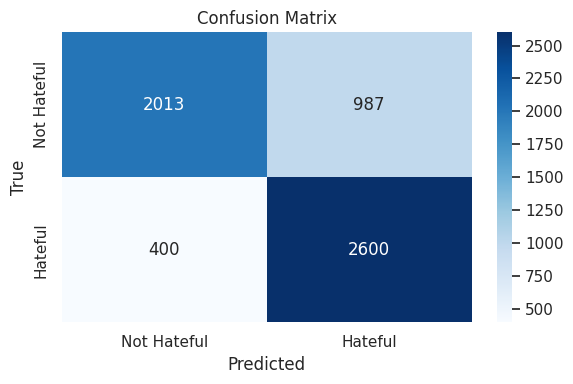

Plotting F1 Score by Function Name...


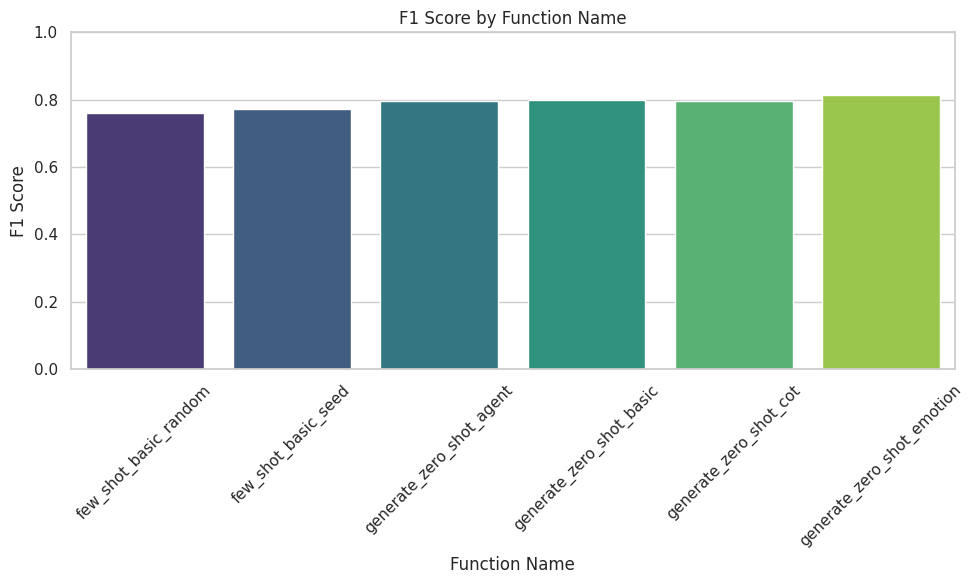

Plotting Misclassifications by Multiclass Class...


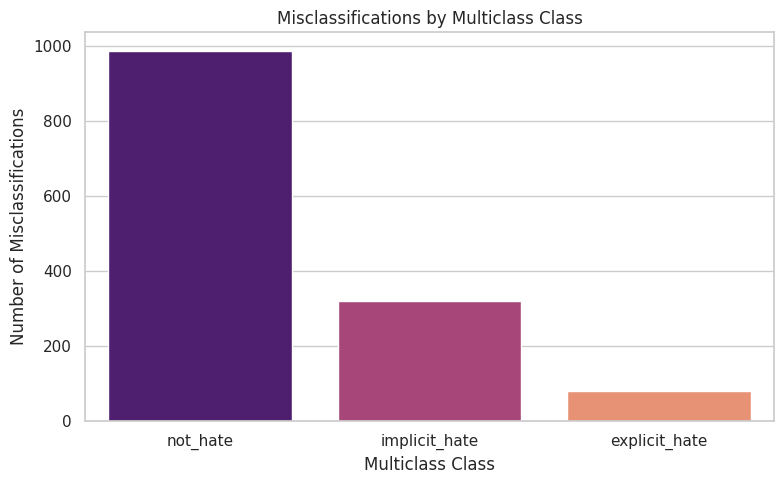

Plotting False Positive Target Groups...


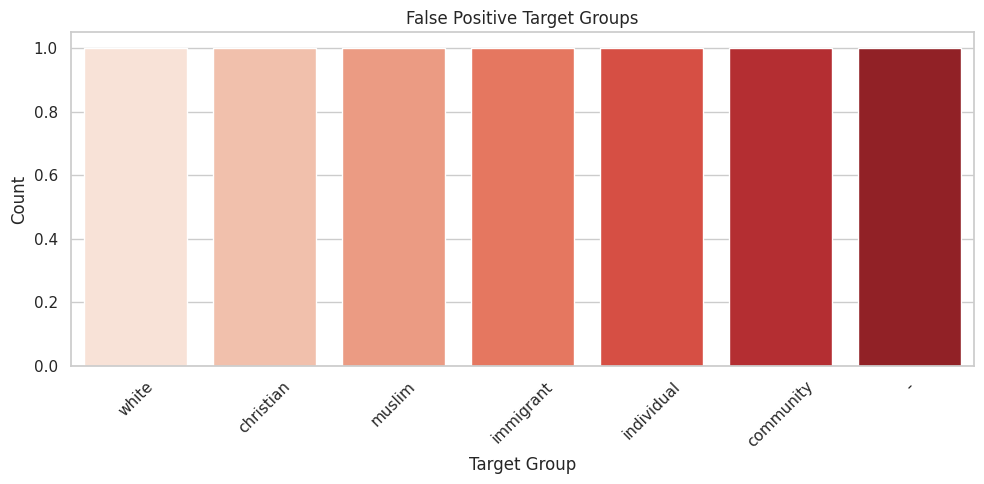

Plotting False Negative Target Groups...


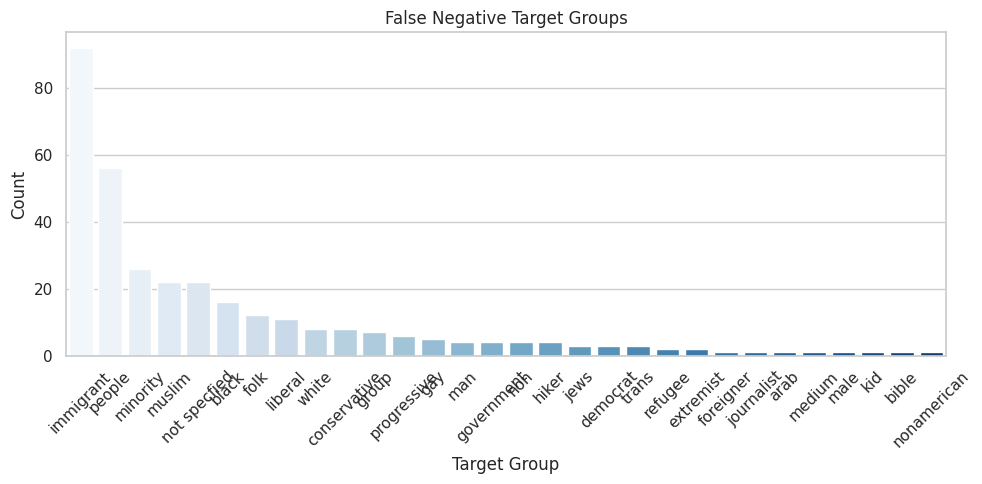

Plotting Top 10 Common Targets: Actual vs Predicted...


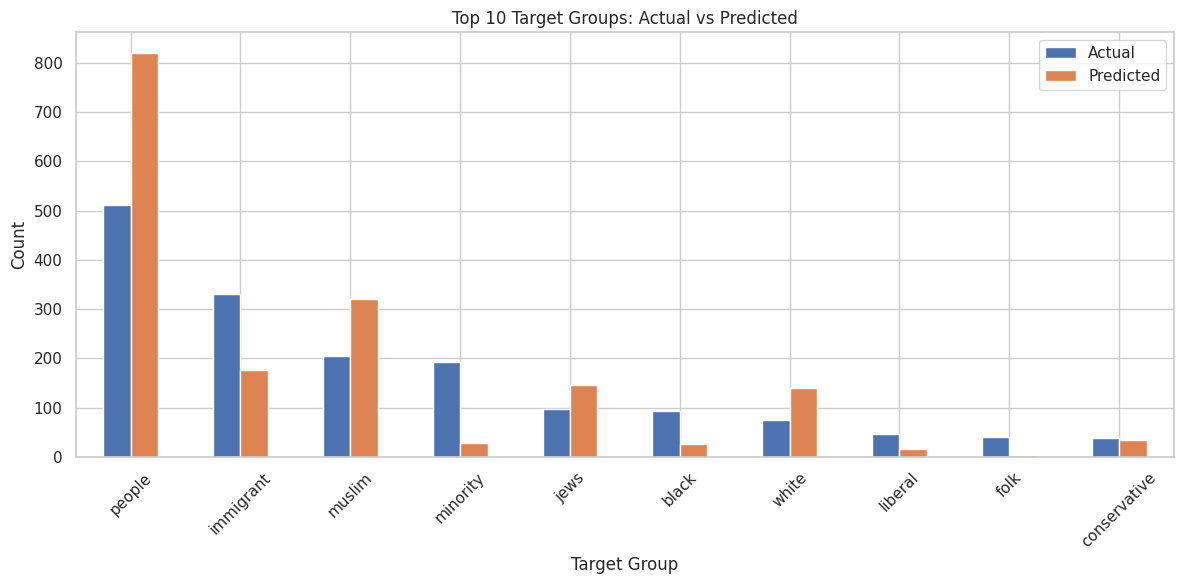

Visualizations complete.


In [ ]:
plot_hate_speech_results(gpt)

## mistral

### printed

In [ ]:
print_hate_speech_metrics(mistral)

=== Overall Classification Metrics ===
Accuracy: 0.76
Precision (Hateful): 0.70
Recall (Hateful): 0.91
F1 Score (Hateful): 0.79

=== Detailed Classification Report ===
              precision    recall  f1-score   support

 Not Hateful       0.87      0.62      0.72      3000
     Hateful       0.70      0.91      0.79      3000

    accuracy                           0.76      6000
   macro avg       0.79      0.76      0.76      6000
weighted avg       0.79      0.76      0.76      6000

=== Metrics by Function Name ===
             function_name  Accuracy  Precision (Hateful)  Recall (Hateful)  F1 Score (Hateful)
     few_shot_basic_random  0.725104             0.648286          0.937500            0.766520
       few_shot_basic_seed  0.744000             0.673789          0.946000            0.787022
  generate_zero_shot_agent  0.790837             0.756098          0.861111            0.805195
  generate_zero_shot_basic  0.723896             0.654114          0.945565            0

### plots

Generating Confusion Matrix...


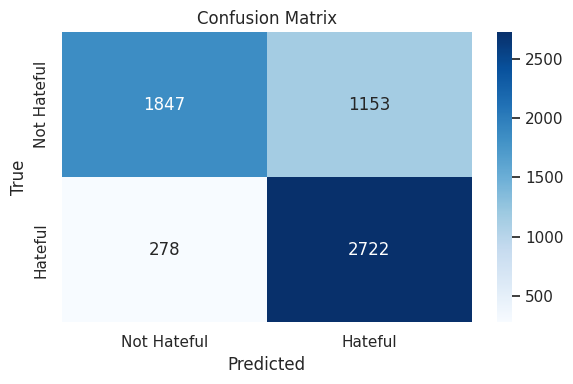

Plotting F1 Score by Function Name...


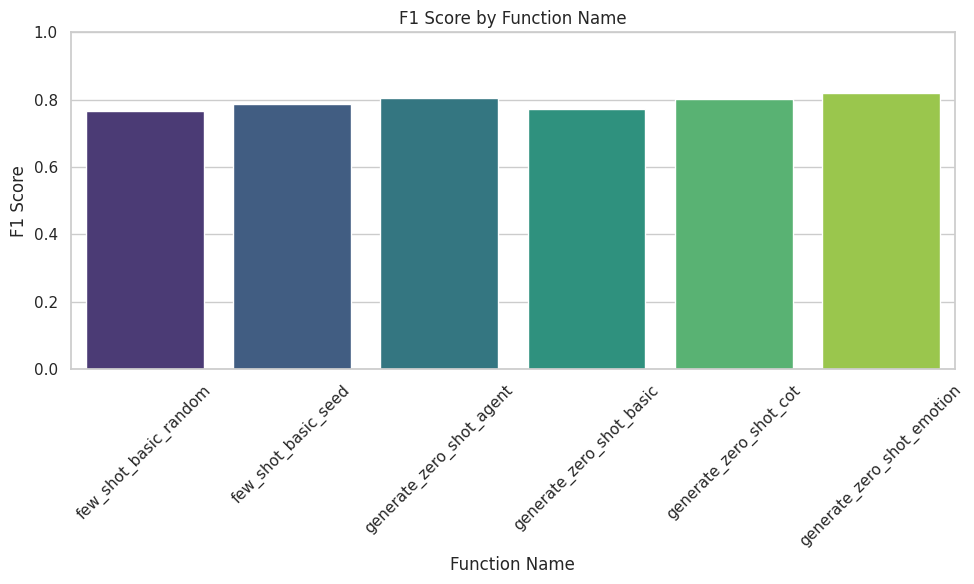

Plotting Misclassifications by Multiclass Class...


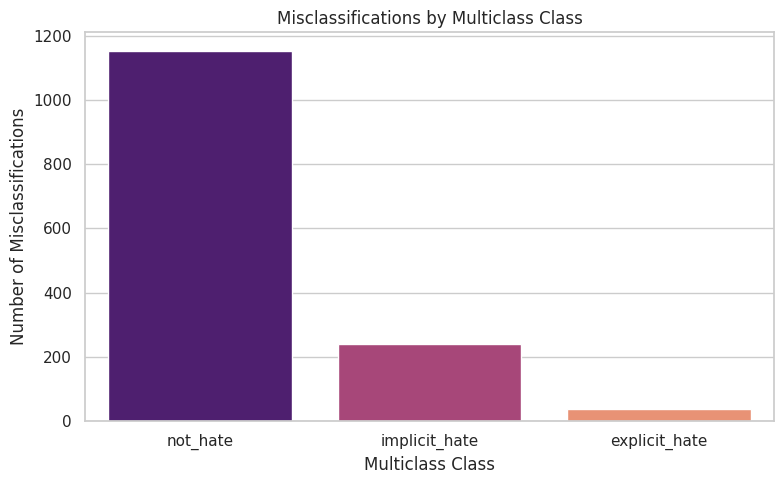

Plotting False Positive Target Groups...


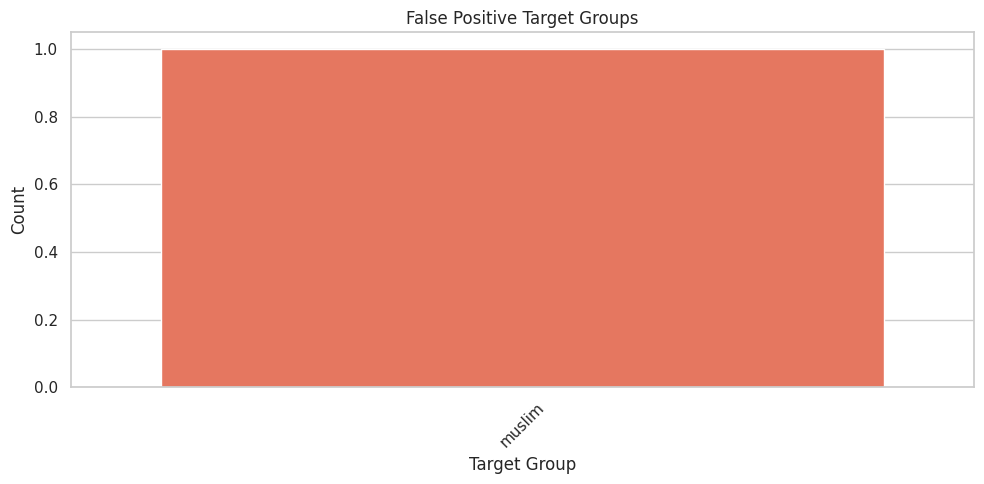

Plotting False Negative Target Groups...


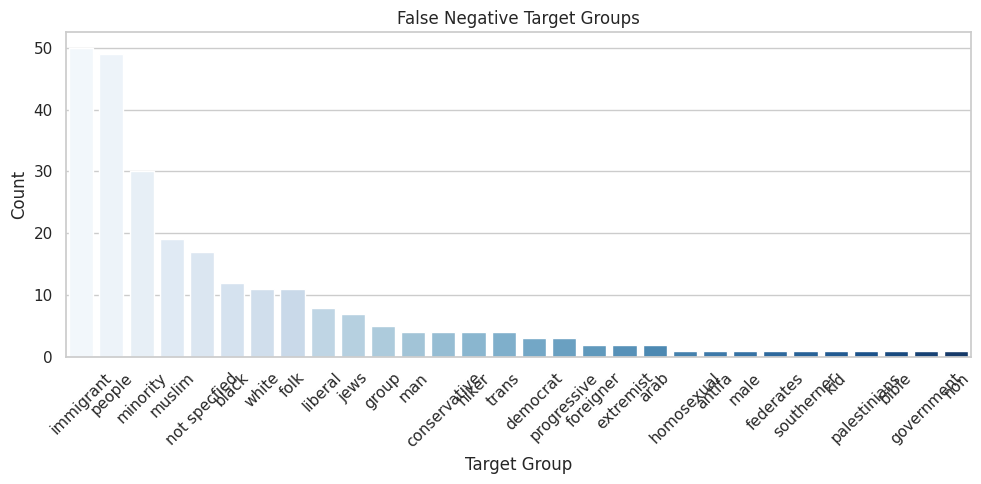

Plotting Top 10 Common Targets: Actual vs Predicted...


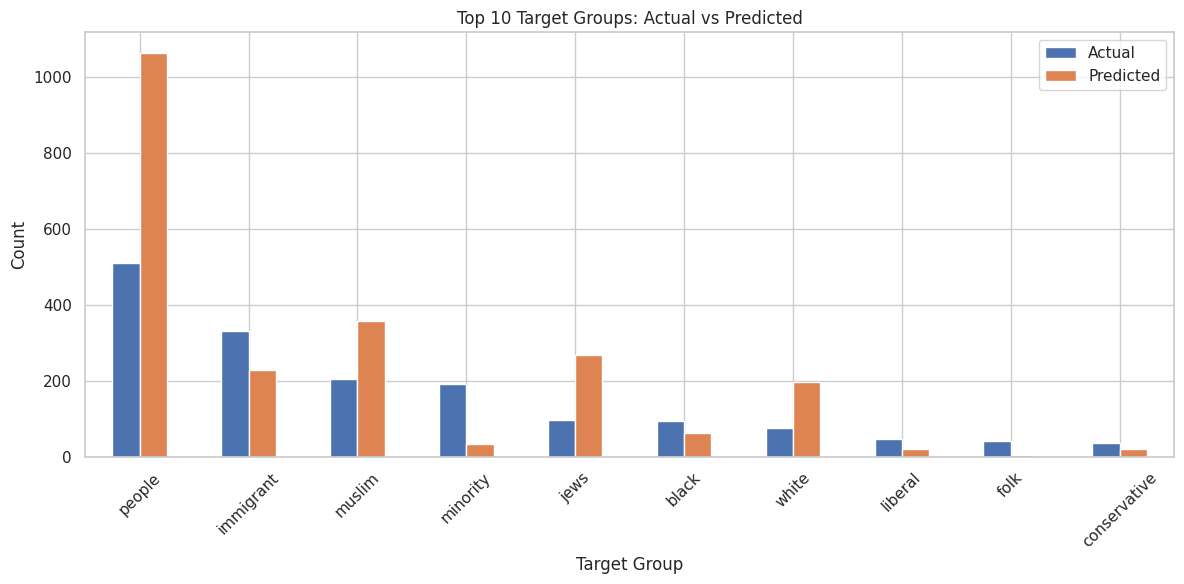

Visualizations complete.


In [ ]:
plot_hate_speech_results(mistral)

# intermediate code for attemtpitng further few-shot analysis by model

In [ ]:
import pandas as pd
import json
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

In [ ]:
mistral_fewshot_df = pd.read_csv('./prompts_fewshot.tsv', sep="\t")
mistral_results = pd.read_csv('results_mistral_fewshot.csv')
gpt_fewshot_df = pd.read_csv('./prompts_fewshot.tsv', sep="\t")
gpt_results = pd.read_csv('results_gpt_fewshot.csv')

In [ ]:
mistral_fewshot_df.head()

,Unnamed: 0,class,target,id,system_prompt,user_prompt,function_name
0,0,implicit_hate,['immigrants'],0,Your goal is to classify text as either 'hatef...,glad not to live in ca. taxpayers pay over 13%...,few_shot_basic_random
1,1,implicit_hate,['immigrants'],0,Your goal is to classify text as either 'hatef...,glad not to live in ca. taxpayers pay over 13%...,few_shot_basic_seed
2,2,implicit_hate,['immigrants'],1,Your goal is to classify text as either 'hatef...,"send all illegals away. no need to """"learn mor...",few_shot_basic_random
3,3,implicit_hate,['immigrants'],1,Your goal is to classify text as either 'hatef...,"send all illegals away. no need to """"learn mor...",few_shot_basic_seed
4,4,not_hate,NaN,2,Your goal is to classify text as either 'hatef...,it is not racist and you are not a hate group ...,few_shot_basic_random


In [ ]:
def extract_class(json_str):
    try:
        json_obj = json.loads(json_str)
        return json_obj.get('class', None)
    except json.JSONDecodeError:
        return None

In [ ]:
mistral_fewshot_df['binary_class'] = mistral_fewshot_df['class'].apply(lambda x: 'not_hate' if x == 'not_hate' else 'hate')
gpt_fewshot_df['binary_class'] = gpt_fewshot_df['class'].apply(lambda x: 'not_hate' if x == 'not_hate' else 'hate')

# Apply the function to the 'output' column
mistral_results['extracted_class'] = mistral_results['output'].apply(extract_class)

# Add the extracted 'class' to the other DataFrame, renaming the column
mistral_fewshot_df['pred_class'] = mistral_results['extracted_class']

# Apply the function to the 'output' column
gpt_results['extracted_class'] = gpt_results['output'].apply(extract_class)

# Add the extracted 'class' to the other DataFrame, renaming the column
gpt_fewshot_df['pred_class'] = gpt_results['extracted_class']

def reduce_df(df):
    # Randomly reduce the number of 'explicit_hate' and 'implicit_hate' rows by half
  classes_to_reduce = ['explicit_hate', 'implicit_hate']
  reduced_dfs = []
  for cls in classes_to_reduce:
      cls_df = df[df['class'] == cls]
      reduced_cls_df = cls_df.sample(frac=0.5, random_state=42)
      reduced_dfs.append(reduced_cls_df)
  # Get the rest of the data
  other_df = df[~df['class'].isin(classes_to_reduce)]
  # Concatenate the dataframes
  new_df = pd.concat(reduced_dfs + [other_df], ignore_index=True)
  print(new_df.value_counts('class'))
  return new_df

mistral_fewshot_df = reduce_df(mistral_fewshot_df)
gpt_fewshot_df = reduce_df(gpt_fewshot_df)

class
not_hate         1000
explicit_hate     500
implicit_hate     500
Name: count, dtype: int64
class
not_hate         1000
explicit_hate     500
implicit_hate     500
Name: count, dtype: int64


In [ ]:
print("=== Metrics by Function Name ===")
function_metrics = mistral_fewshot_df.groupby('function_name').apply(
    lambda x: pd.Series({
        'Accuracy': accuracy_score(x['binary_class'], x['pred_class']),
        'Precision (Hateful)': precision_score(x['binary_class'], x['pred_class'], pos_label='hate', zero_division=0),
        'Recall (Hateful)': recall_score(x['binary_class'], x['pred_class'], pos_label='hate', zero_division=0),
        'F1 Score (Hateful)': f1_score(x['binary_class'], x['pred_class'], pos_label='hate', zero_division=0)
    })
).reset_index()
print(function_metrics.to_string(index=False))
print()

=== Metrics by Function Name ===
        function_name  Accuracy  Precision (Hateful)  Recall (Hateful)  F1 Score (Hateful)
few_shot_basic_random  0.648703             0.591463          0.966135            0.733737
  few_shot_basic_seed  0.645291             0.588235          0.963855            0.730594



<ipython-input-19-8556aeaa9a82>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  function_metrics = mistral_fewshot_df.groupby('function_name').apply(


In [ ]:
print("=== Metrics by Function Name ===")
function_metrics = gpt_fewshot_df.groupby('function_name').apply(
    lambda x: pd.Series({
        'Accuracy': accuracy_score(x['binary_class'], x['pred_class']),
        'Precision (Hateful)': precision_score(x['binary_class'], x['pred_class'], pos_label='hate', zero_division=0),
        'Recall (Hateful)': recall_score(x['binary_class'], x['pred_class'], pos_label='hate', zero_division=0),
        'F1 Score (Hateful)': f1_score(x['binary_class'], x['pred_class'], pos_label='hate', zero_division=0)
    })
).reset_index()
print(function_metrics.to_string(index=False))
print()

=== Metrics by Function Name ===
        function_name  Accuracy  Precision (Hateful)  Recall (Hateful)  F1 Score (Hateful)
few_shot_basic_random  0.776447             0.728618          0.882470            0.798198
  few_shot_basic_seed  0.748497             0.702791          0.859438            0.773261



<ipython-input-21-bc26e54b3a8d>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  function_metrics = gpt_fewshot_df.groupby('function_name').apply(
